In [56]:
# 1. Import library
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import smote_variants as sv
RANDOM_STATE = 42
pd.set_option("display.max_columns", None)


In [57]:
df = pd.read_csv("framingham.csv")

In [58]:
# 3. Pilih 8 fitur utama
selected_features = [
"male", "age", "currentSmoker", "cigsPerDay", "BPMeds", 
    "prevalentHyp", "diabetes", "totChol", 
    "sysBP", "glucose"
]

In [59]:

target_col = "TenYearCHD"

# Pastikan semua kolom ada
print("Kolom yang digunakan:")
print(selected_features + [target_col])
print(df[selected_features + [target_col]].head())

Kolom yang digunakan:
['male', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'glucose', 'TenYearCHD']
   male  age  currentSmoker  cigsPerDay  BPMeds  prevalentHyp  diabetes  \
0     1   39              0         0.0     0.0             0         0   
1     0   46              0         0.0     0.0             0         0   
2     1   48              1        20.0     0.0             0         0   
3     0   61              1        30.0     0.0             1         0   
4     0   46              1        23.0     0.0             0         0   

   totChol  sysBP  glucose  TenYearCHD  
0    195.0  106.0     77.0           0  
1    250.0  121.0     76.0           0  
2    245.0  127.5     70.0           0  
3    225.0  150.0    103.0           1  
4    285.0  130.0     85.0           0  


Shape awal: (4240, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   male           4240 non-null   int64  
 1   age            4240 non-null   int64  
 2   currentSmoker  4240 non-null   int64  
 3   cigsPerDay     4211 non-null   float64
 4   BPMeds         4187 non-null   float64
 5   prevalentHyp   4240 non-null   int64  
 6   diabetes       4240 non-null   int64  
 7   totChol        4190 non-null   float64
 8   sysBP          4240 non-null   float64
 9   glucose        3852 non-null   float64
 10  TenYearCHD     4240 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 364.5 KB
None
              male          age  currentSmoker   cigsPerDay       BPMeds  \
count  4240.000000  4240.000000    4240.000000  4211.000000  4187.000000   
mean      0.429245    49.580189       0.494104     9.005937     0.029615   
std       0.4

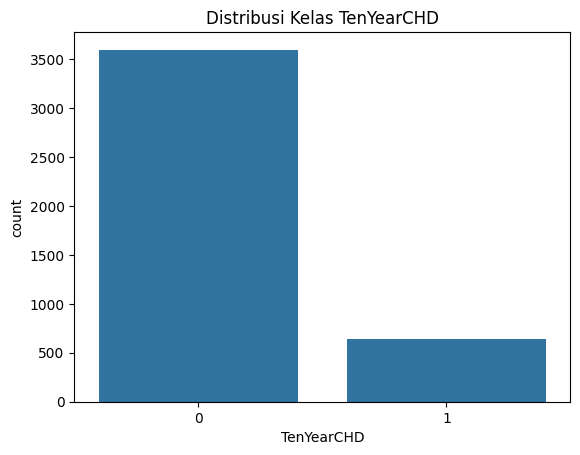

<Figure size 1200x800 with 0 Axes>

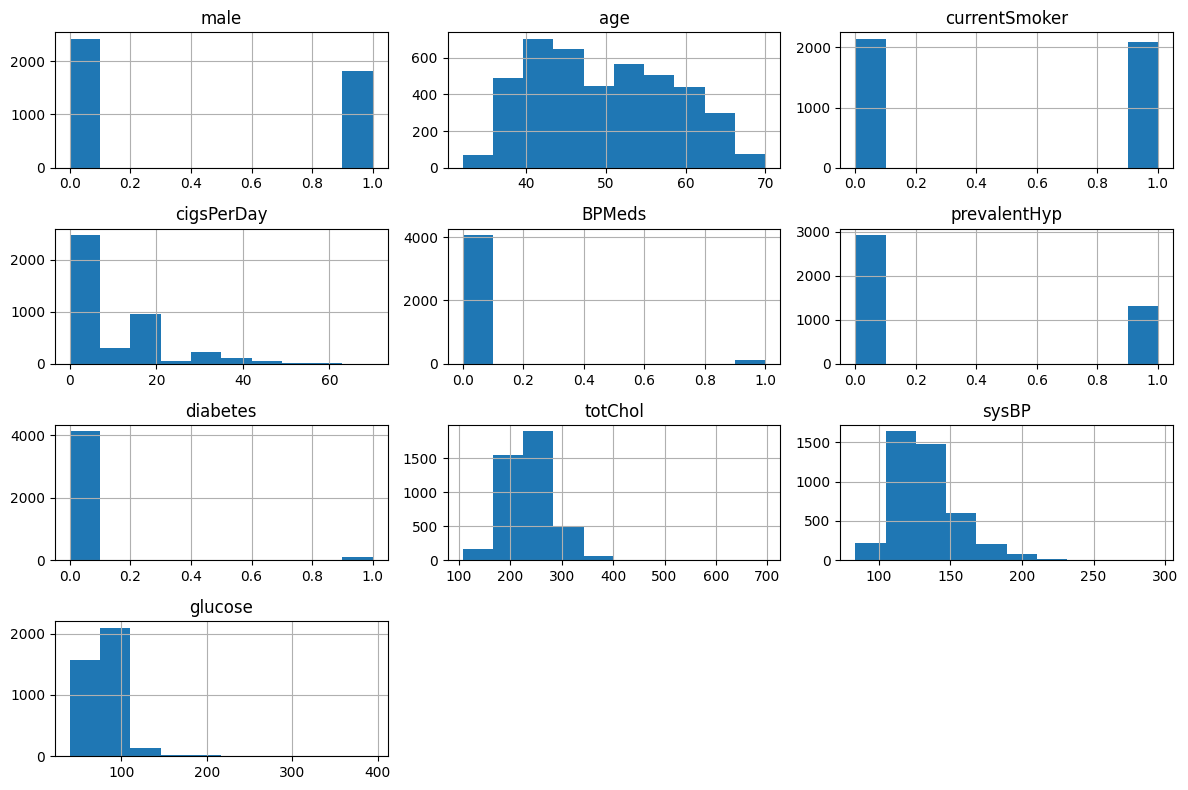

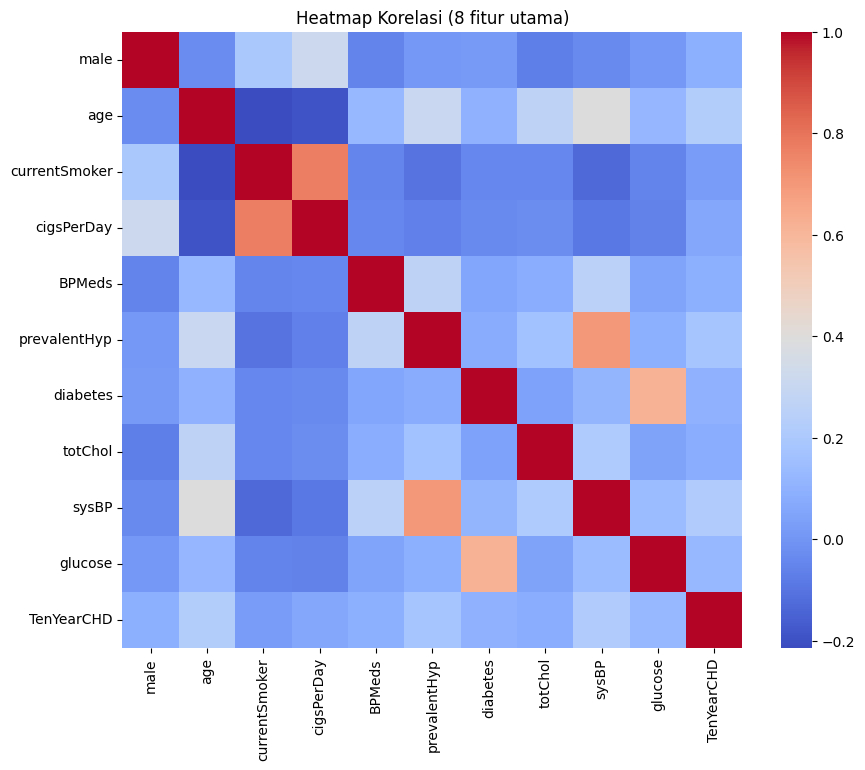

In [60]:
# 4. Explorasi data singkat
print("Shape awal:", df.shape)
print(df[selected_features + [target_col]].info())
print(df[selected_features + [target_col]].describe())

print("\nDistribusi kelas TenYearCHD:")
print(df[target_col].value_counts())
print(df[target_col].value_counts(normalize=True))

plt.figure()
sns.countplot(x=target_col, data=df)
plt.title("Distribusi Kelas TenYearCHD")
plt.show()

plt.figure(figsize=(12, 8))
df[selected_features].hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
corr = df[selected_features + [target_col]].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Heatmap Korelasi (8 fitur utama)")
plt.show()


In [61]:
# 5. Pre-processing

# Imputasi mean untuk missing values di fitur + target (kalau ada)
for col in selected_features + [target_col]:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mean())

X = df[selected_features]
y = df[target_col].astype(int)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [62]:
# 6. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.1,
    random_state=RANDOM_STATE,
    stratify=y
)

In [63]:

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Distribusi kelas train:")
print(pd.Series(y_train).value_counts(normalize=True))
print("Distribusi kelas test:")
print(pd.Series(y_test).value_counts(normalize=True))

Train shape: (3816, 10) Test shape: (424, 10)
Distribusi kelas train:
TenYearCHD
0    0.848008
1    0.151992
Name: proportion, dtype: float64
Distribusi kelas test:
TenYearCHD
0    0.849057
1    0.150943
Name: proportion, dtype: float64


In [64]:
# 7. Definisi SMOTE-IPF

class SMOTE_IPF(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_strategy=0.6, smote_k=5, ipf_k=3,
                 max_iter=5, random_state=None, verbose=False):
        self.sampling_strategy = sampling_strategy
        self.smote_k = smote_k
        self.ipf_k = ipf_k
        self.max_iter = max_iter
        self.random_state = random_state
        self.verbose = verbose

    def fit(self, X, y=None):
        return self

    def fit_resample(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y).ravel()

        smote = SMOTE(
            sampling_strategy=self.sampling_strategy,
            k_neighbors=self.smote_k,
            random_state=self.random_state
        )
        X_res, y_res = smote.fit_resample(X, y)

        for it in range(self.max_iter):
            knn = KNeighborsClassifier(n_neighbors=self.ipf_k)
            knn.fit(X_res, y_res)
            y_pred = knn.predict(X_res)

            misclassified = y_pred != y_res
            if not np.any(misclassified):
                if self.verbose:
                    print(f"Iterasi {it+1}: tidak ada noise, berhenti.")
                break

            minority_class = 1 if np.sum(y_res == 1) < np.sum(y_res == 0) else 0
            idx_noise = np.where(misclassified & (y_res == minority_class))[0]

            if len(idx_noise) == 0:
                if self.verbose:
                    print(f"Iterasi {it+1}: tidak ada noise di kelas minoritas, berhenti.")
                break

            if self.verbose:
                print(f"Iterasi {it+1}: menghapus {len(idx_noise)} sampel noise.")

            mask_keep = np.ones(len(X_res), dtype=bool)
            mask_keep[idx_noise] = False
            X_res = X_res[mask_keep]
            y_res = y_res[mask_keep]

        return X_res, y_res

In [65]:
# 8. Fungsi evaluasi

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n=== {name} ===")
    print("Accuracy :", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1-score :", f1)
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }

results = []

In [66]:
# 9. Skenario 1: Baseline (tanpa oversampling)

svm_baseline = SVC(
    kernel="linear",
    C=10,
    gamma=1,
    random_state=RANDOM_STATE
)
svm_baseline.fit(X_train, y_train)
y_pred_baseline = svm_baseline.predict(X_test)

results.append(evaluate_model("SVM Baseline (Tanpa Oversampling)", y_test, y_pred_baseline))


=== SVM Baseline (Tanpa Oversampling) ===
Accuracy : 0.8490566037735849
Precision: 0.0
Recall   : 0.0
F1-score : 0.0

Confusion Matrix:
[[360   0]
 [ 64   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       360
           1       0.00      0.00      0.00        64

    accuracy                           0.85       424
   macro avg       0.42      0.50      0.46       424
weighted avg       0.72      0.85      0.78       424



In [67]:
# 10. Skenario 2: SMOTE

smote = SMOTE(
    sampling_strategy=0.5,
    random_state=RANDOM_STATE
)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

svm_smote = SVC(
    kernel="rbf",
    C=10,
    gamma=1,
    random_state=RANDOM_STATE
)
svm_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = svm_smote.predict(X_test)

results.append(evaluate_model("SVM + SMOTE", y_test, y_pred_smote))


=== SVM + SMOTE ===
Accuracy : 0.7924528301886793
Precision: 0.2777777777777778
Recall   : 0.234375
F1-score : 0.2542372881355932

Confusion Matrix:
[[321  39]
 [ 49  15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       360
           1       0.28      0.23      0.25        64

    accuracy                           0.79       424
   macro avg       0.57      0.56      0.57       424
weighted avg       0.78      0.79      0.79       424



In [68]:
# 11. Skenario 3: SMOTE-IPF

smote_ipf = SMOTE_IPF(
    sampling_strategy=0.8,
    smote_k=150,
    ipf_k=150,
    max_iter=50,
    random_state=RANDOM_STATE,
    verbose=False
)
X_train_smote_ipf, y_train_smote_ipf = smote_ipf.fit_resample(X_train, y_train)

svm_smote_ipf = SVC(
    kernel="rbf",
    C=10,
    gamma=1,
    random_state=RANDOM_STATE
)
svm_smote_ipf.fit(X_train_smote_ipf, y_train_smote_ipf)
y_pred_smote_ipf = svm_smote_ipf.predict(X_test)

results.append(evaluate_model("SVM + SMOTE-IPF", y_test, y_pred_smote_ipf))


=== SVM + SMOTE-IPF ===
Accuracy : 0.8443396226415094
Precision: 0.4444444444444444
Recall   : 0.125
F1-score : 0.1951219512195122

Confusion Matrix:
[[350  10]
 [ 56   8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       360
           1       0.44      0.12      0.20        64

    accuracy                           0.84       424
   macro avg       0.65      0.55      0.55       424
weighted avg       0.80      0.84      0.81       424



In [69]:
#smote-ipf with smote variant
print(f"Data Training Asli: {len(X_train)}")
print(f"Data Testing Asli : {len(X_test)}")

Data Training Asli: 3816
Data Testing Asli : 424


In [70]:
print("\nSedang melakukan SMOTE-IPF pada Data Training...")
oversampler = sv.SMOTE_IPF(
    k = 5,
    n_folds=5,
    p=0.5,
    n_jobs= 1
)


Sedang melakukan SMOTE-IPF pada Data Training...


In [71]:
X_train_res, y_train_res = oversampler.sample(X_train, y_train)

print(f"Data Training Setelah SMOTE-IPF: {len(X_train_res)}")

2026-01-07 12:08:10,821:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 5, 'k': 5, 'p': 0.5, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': None, 'class_name': 'SMOTE_IPF'}")
2026-01-07 12:08:10,822:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'SMOTE'}")
2026-01-07 12:08:10,824:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2026-01-07 12:08:10,826:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2026-01-07 12:08:10,832:INFO:SMOTE: simplex sampling with n_d

Data Training Setelah SMOTE-IPF: 6471


In [72]:
scaler = StandardScaler()

In [73]:
# Fit pada data training yang sudah di-SMOTE
X_train_final = scaler.fit_transform(X_train_res)

# Transform data testing (pakai skala dari training, jangan di-fit ulang!)
X_test_final = scaler.transform(X_test)

In [74]:
# --- 5. KLASIFIKASI MENGGUNAKAN SVM ---
print("\nSedang melatih model SVM...")
# Kernel RBF biasanya standar terbaik, tapi bisa diganti Linear/Poly
svm_model = SVC(kernel='rbf', C=10, gamma=1, random_state=RANDOM_STATE) 
svm_model.fit(X_train_final, y_train_res)


Sedang melatih model SVM...


,C,10
,kernel,'rbf'
,degree,3
,gamma,1
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [75]:
# --- 6. EVALUASI ---
y_pred = svm_model.predict(X_test_final)

print("\n=== HASIL EVALUASI ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Akurasi: {accuracy_score(y_test, y_pred)}")


=== HASIL EVALUASI ===
Confusion Matrix:
[[282  78]
 [ 46  18]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       360
           1       0.19      0.28      0.23        64

    accuracy                           0.71       424
   macro avg       0.52      0.53      0.52       424
weighted avg       0.76      0.71      0.73       424

Akurasi: 0.7075471698113207


In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# 1. Definisikan Grid Parameter untuk dicoba
param_grid = {
    'C': [0.1, 1, 10],            # C lebih kecil = lebih general (mengurangi False Positive)
    'gamma': [1, 0.1, 0.01],      # Gamma mengatur seberapa detail boundary-nya
    'kernel': ['rbf']             # Coba kernel RBF (biasanya lebih bagus dari Linear)
}

# 2. Jalankan Grid Search pada data yang SUDAH di-SMOTE dan Scaled
# Pastikan pakai X_train_final dan y_train_res dari kodemu sebelumnya
print("Sedang mencari parameter terbaik...")
grid = GridSearchCV(SVC(random_state=42), param_grid, refit=True, verbose=2, cv=3, scoring='f1')
grid.fit(X_train_final, y_train_res)

# 3. Tampilkan hasil terbaik
print(f"Parameter Terbaik: {grid.best_params_}")

# 4. Evaluasi ulang dengan parameter terbaik
best_model = grid.best_estimator_
y_pred_new = best_model.predict(X_test_final)

print("\n=== HASIL SETELAH TUNING ===")
print(classification_report(y_test, y_pred_new))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_new))

Sedang mencari parameter terbaik...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.1s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   1.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   1.1s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   1.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.9s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   1.0s
[CV] END ....